In [2]:
from data_processing import get_data
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers import Input, LSTM, Dense, concatenate
from keras import Model, optimizers, losses, metrics
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
normal_data, abnormal_data, _, _ = get_data("york")

Normal data shape: (8200, 101)
Abnormal data shape: (1620, 101)
Real abnormal data shape: (2, 1)
Real abnormal data 2 shape: (2, 1)


C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [4]:
data = np.concatenate([normal_data, abnormal_data])
data.shape

(9820, 101)

In [5]:
db = DBSCAN(eps=0.2).fit(data)
labels_cluster = db.labels_
labels_cluster = np.reshape(labels_cluster, [-1, 1])
labels_cluster.shape

(9820, 1)

In [6]:
labels_cluster[labels_cluster != -1] = 1
labels_cluster[labels_cluster == -1] = 0

In [7]:
# Create the labels, since we will be doing supervised learning. 1 represents a normal trajectory, 0 is abnormal
labels = np.concatenate([
    np.ones(normal_data.shape[0]),
    np.zeros(abnormal_data.shape[0])
], 0)

labels = np.reshape(labels, [-1, 1])
labels.shape

(9820, 1)

In [8]:
# Let's see the distribution of normal and abnormal data
neg, pos = tf.math.bincount(labels_cluster)
total = neg + pos
print('Examples:\n    Total: {}\n    Normal: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 9820
    Normal: 9561 (97.36% of total)



In [9]:
# Let's see the distribution of normal and abnormal data
neg, pos = tf.math.bincount(labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Normal: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 9820
    Normal: 8200 (83.50% of total)



In [10]:
diff = labels - labels_cluster
correct_normal = len(diff[(diff == 0) & (labels == 1)]) * 100 / pos
correct_abnormal = len(diff[(diff == 0) & (labels == 0)]) * 100 / neg
print(f"Normal accuracy: {correct_normal:.2f}")
print(f"Abnormal accuracy: {correct_abnormal:.2f}")
print(f"Mean accuracy: {(correct_normal + correct_abnormal) / 2:.2f}")
# print(f"Misclassified normal: {false_neg}")
# print(f"Misclassified abnormal: {false_pos}")
# print(f"Accuracy: {correct * 100 / len(labels):.2f}%")

Normal accuracy: 100.00
Abnormal accuracy: 15.99
Mean accuracy: 57.99


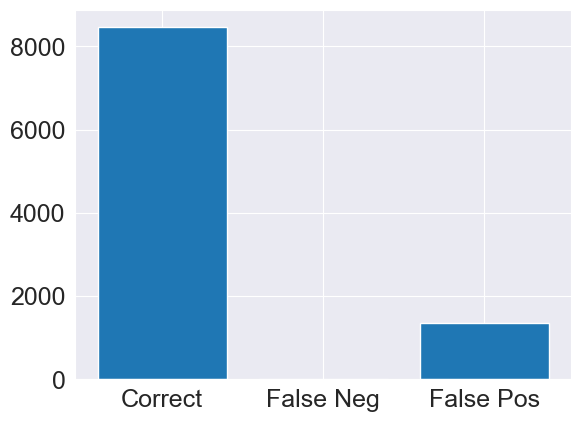

In [11]:
correct = len(diff[diff == 0])
false_neg = len(diff[diff == 1])
false_pos = len(diff[diff == -1])

plt.rcParams.update({'font.size': 18})
# plt.xticks([0, 1])
plt.bar(["Correct", "False Neg", "False Pos"], [correct, false_neg, false_pos])
plt.show()

In [12]:
data = np.concatenate([data, labels_cluster, labels], 1)
data.shape

(9820, 103)

In [13]:
train_data, test_data = train_test_split(data, test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)

In [14]:
train_labels = train_data[:,-2].astype('int32')
train_categories = train_data[:,0].astype('int32')
train_data = train_data[:,1:-2]

val_labels = val_data[:,-1].astype('int32')
val_categories = val_data[:,0].astype('int32')
val_data = val_data[:,1:-2]

test_labels = test_data[:,-1].astype('int32')
test_categories = test_data[:,0].astype('int32')
test_data = test_data[:,1:-2]

In [15]:
print(train_labels.shape)
print(train_categories.shape)
print(train_data.shape)

(6284,)
(6284,)
(6284, 100)


In [16]:
# The category data needs to be one-hot encoded
train_categories = np.reshape(train_categories, newshape=[-1, 1])
val_categories = np.reshape(val_categories, newshape=[-1, 1])
test_categories = np.reshape(test_categories, newshape=[-1, 1])

one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(train_categories)
one_hot_encoder.fit(val_categories)
one_hot_encoder.fit(test_categories)

train_categories = one_hot_encoder.transform(train_categories)
val_categories = one_hot_encoder.transform(val_categories)
test_categories = one_hot_encoder.transform(test_categories)

In [17]:
train_categories.shape

(6284, 2)

In [18]:
# The trajectory data however needs to be reshaped into data containing 31 timesteps for 4 features.
# The trajectory features are the x and y location, and the x and y velocities over 31 timesteps

features = 4
timesteps = int(train_data.shape[1] / features)

train_data = np.transpose(np.reshape(train_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])
val_data = np.transpose(np.reshape(val_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])
test_data = np.transpose(np.reshape(test_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])

train_data.shape

(6284, 4, 25)

In [19]:
train_labels.shape

(6284,)

In [20]:
bool_train_labels = train_labels != 0

pos_features = train_data[bool_train_labels]
neg_features = train_data[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

pos_categories = train_categories[bool_train_labels]
neg_categories = train_categories[~bool_train_labels]

In [21]:
ids = np.arange(len(neg_features))
choices = np.random.choice(ids, len(pos_features))

res_neg_features = neg_features[choices]
res_neg_labels = neg_labels[choices]
res_neg_categories = neg_categories[choices]

res_neg_features.shape

(6112, 4, 25)

In [22]:
resampled_features = np.concatenate([res_neg_features, pos_features], axis=0)
resampled_labels = np.concatenate([res_neg_labels, pos_labels], axis=0)
resampled_categories = np.concatenate([res_neg_categories, pos_categories], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]
resampled_categories = resampled_categories[order]

print(resampled_features.shape)
print(resampled_labels.shape)
print(resampled_categories.shape)

(12224, 4, 25)
(12224,)
(12224, 2)


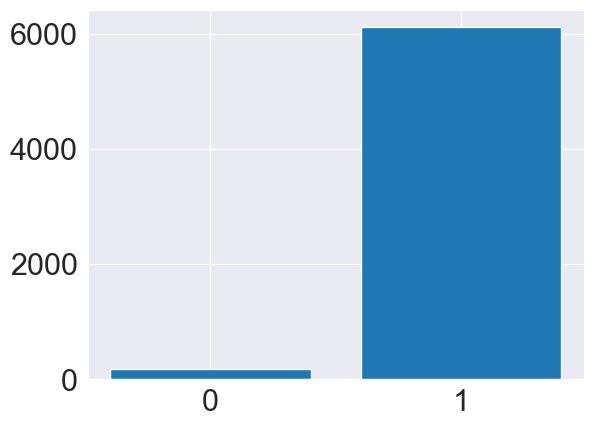

In [23]:
neg, pos = tf.math.bincount(train_labels)

plt.rcParams.update({'font.size': 22})
plt.xticks([0, 1])
plt.bar([0, 1], [neg, pos])
plt.show()

In [24]:
BATCH_SIZE=128

resampled_steps_per_epoch = np.ceil(2.0*pos.numpy()/BATCH_SIZE)
resampled_steps_per_epoch

96.0

In [25]:
# Now to define the network

# Trajectory data
trajectory_input_shape = resampled_features.shape[1:]
units = 100
trajectory_input = Input(shape=trajectory_input_shape)
trajectory_output = LSTM(units)(trajectory_input)

# Category data
category_input = Input(shape=resampled_categories.shape[1:])

# Merge and add dense layer
merge_layer = concatenate([category_input, trajectory_output])
main_output = Dense(units=1,activation="sigmoid")(merge_layer)

# Define the model with two inputs
model = Model(inputs=[trajectory_input, category_input], outputs=[main_output])

In [26]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'),
      metrics.BinaryAccuracy(name='accuracy')
]

model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=METRICS
)

In [27]:
EPOCHS = 20

resampled_history = model.fit(
    [resampled_features, resampled_categories],
    resampled_labels,
    # These are not real epochs
    steps_per_epoch=resampled_steps_per_epoch,
    epochs=EPOCHS,
    validation_data=([val_data, val_categories], val_labels))

Epoch 1/20
96/96 [==============================] - 5s 18ms/step - loss: 0.6710 - tp: 3183.0000 - fp: 2456.0000 - tn: 3656.0000 - fn: 2929.0000 - accuracy: 0.5595 - val_loss: 0.5474 - val_tp: 927.0000 - val_fp: 91.0000 - val_tn: 161.0000 - val_fn: 393.0000 - val_accuracy: 0.6921
Epoch 2/20
96/96 [==============================] - 1s 12ms/step - loss: 0.5844 - tp: 3466.0000 - fp: 1032.0000 - tn: 5080.0000 - fn: 2646.0000 - accuracy: 0.6991 - val_loss: 0.4827 - val_tp: 950.0000 - val_fp: 39.0000 - val_tn: 213.0000 - val_fn: 370.0000 - val_accuracy: 0.7398
Epoch 3/20
96/96 [==============================] - 1s 11ms/step - loss: 0.5226 - tp: 4181.0000 - fp: 1080.0000 - tn: 5032.0000 - fn: 1931.0000 - accuracy: 0.7537 - val_loss: 0.3647 - val_tp: 1157.0000 - val_fp: 52.0000 - val_tn: 200.0000 - val_fn: 163.0000 - val_accuracy: 0.8632
Epoch 4/20
96/96 [==============================] - 1s 12ms/step - loss: 0.4888 - tp: 4670.0000 - fp: 1117.0000 - tn: 4995.0000 - fn: 1442.0000 - accuracy: 0.7

In [28]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, metric):
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    # else:
    #   plt.ylim([0.7,1])

    plt.legend()

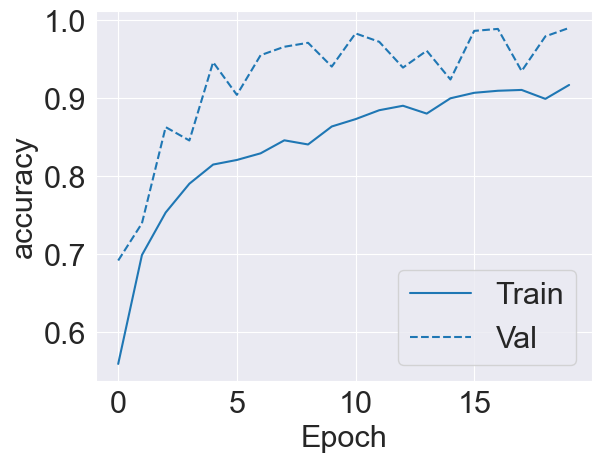

In [29]:
plot_metrics(resampled_history, "accuracy")

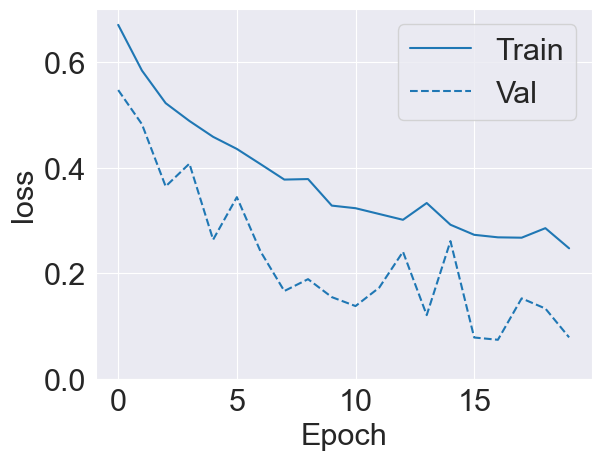

In [30]:
plot_metrics(resampled_history, "loss")

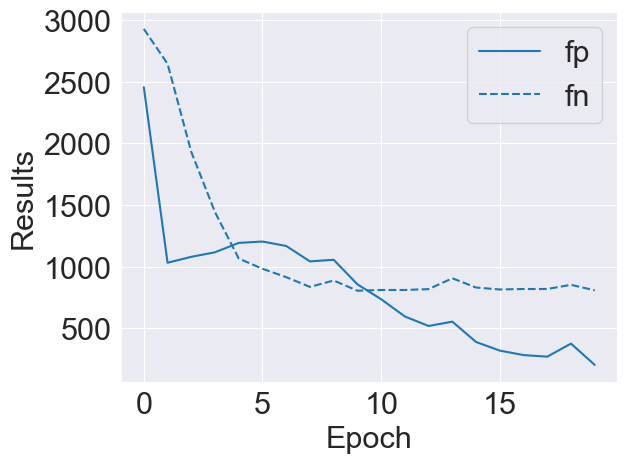

In [37]:
plt.plot(resampled_history.epoch, resampled_history.history['fp'], color=colors[0], label='fp')
plt.plot(resampled_history.epoch, resampled_history.history['fn'], color=colors[0], linestyle="--", label='fn')
plt.xlabel('Epoch')
plt.ylabel('Results')

plt.legend()

In [32]:
resampled_results = model.evaluate([test_data, test_categories], test_labels, batch_size=BATCH_SIZE, verbose=0)

In [33]:
for name, value in zip(model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

loss :  0.08020152151584625
tp :  1620.0
fp :  6.0
tn :  325.0
fn :  13.0
accuracy :  0.9903258681297302



In [34]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [35]:
test_predictions = model.predict([test_data, test_categories], batch_size=BATCH_SIZE)

16/16 [==============================] - 0s 3ms/step


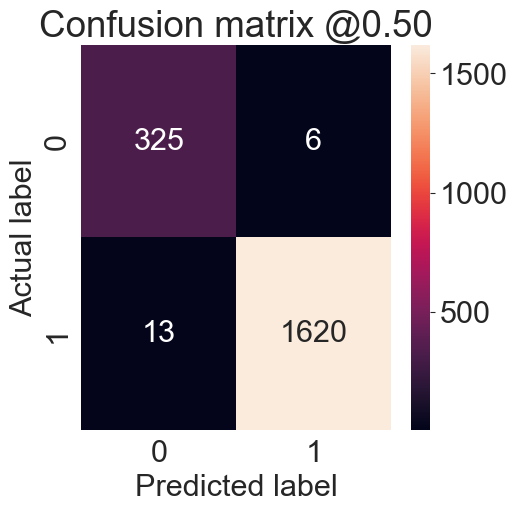

In [36]:
plot_cm(test_labels, test_predictions)

In [38]:
pred = [0 if p < 0.5 else 1 for p in test_predictions]
wrong_predictions = [i for i in range(len(pred)) if pred[i] != test_labels[i]]
len(wrong_predictions)

19

In [39]:
wrong_trajectories = test_data[wrong_predictions]
wrong_categories = test_categories[wrong_predictions]

In [40]:
wrong_trajectories = np.reshape(np.transpose(wrong_trajectories, axes=[0, 2, 1]), [wrong_trajectories.shape[0], 100])

In [51]:
show_traj = []
for j in range(len(wrong_trajectories)):
    for i, d in enumerate(data):
        if np.array_equiv(d[1:-2], wrong_trajectories[j]):
            show_traj.append(i)
            break

In [52]:
show_traj

[7827,
 7816,
 8030,
 8120,
 8189,
 8079,
 8204,
 8280,
 67,
 8423,
 7852,
 3589,
 7956,
 8250,
 7821,
 17,
 8201,
 226,
 8681]

In [53]:
normal_data.shape

(8200, 101)